# Data Preprocessing

In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Load raw data

In [181]:
kz_data = pd.read_csv('/Users/kassi/Data Mining/Final/Code/data/orginal/kz_data_en.csv')
foreign_data = pd.read_csv('/Users/kassi/Data Mining/Final/Code/data/orginal/student_portuguese.csv')

In [182]:
print(f"Kazakhstan: {kz_data.shape}")
print(f"Foreign: {foreign_data.shape}")

Kazakhstan: (121, 29)
Foreign: (649, 34)


#  Missing Values Analysis

In [183]:
def analyze_missing(df, name):
    """Analyze missing values in dataset"""
    print(f"\n=== {name} Missing Values Analysis ===")
    
    missing = df.isnull().sum()
    missing_pct = (missing / len(df) * 100).round(2)
    
    missing_df = pd.DataFrame({
        'Column': missing.index,
        'Missing_Count': missing.values,
        'Percentage': missing_pct.values
    })
    
    missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Percentage', ascending=False)
    
    if len(missing_df) > 0:
        print(missing_df.to_string(index=False))
    else:
        print("No missing values!")
    
    return missing_df

kz_missing = analyze_missing(kz_data, "Kazakhstan")
foreign_missing = analyze_missing(foreign_data, "Foreign")


=== Kazakhstan Missing Values Analysis ===
           Column  Missing_Count  Percentage
  academic_stress            121      100.00
academic_failures             17       14.05
   nursery_school              6        4.96
employment_status              1        0.83

=== Foreign Missing Values Analysis ===
No missing values!


# Handle Missing Values - Kazakhstan

In [184]:
def handle_missing_kz(df):
    """Handle missing values in Kazakhstan dataset"""
    df = df.copy()
    
    # Strategy 1: Drop rows where GPA is missing (target variable)
    if 'GPA' in df.columns:
        df = df.dropna(subset=['GPA'])
        print(f"Dropped rows with missing GPA. New shape: {df.shape}")
    
    # Strategy 2: Fill numerical with median
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    for col in numerical_cols:
        if df[col].isnull().sum() > 0:
            median_val = df[col].median()
            df[col].fillna(median_val, inplace=True)
            print(f"Filled {col} with median: {median_val}")
    
    # Strategy 3: Fill categorical with mode
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if df[col].isnull().sum() > 0:
            mode_val = df[col].mode()[0]
            df[col].fillna(mode_val, inplace=True)
            print(f"Filled {col} with mode: {mode_val}")
    
    return df

kz_data_clean = handle_missing_kz(kz_data)
print(f"\nKazakhstan dataset after handling missing: {kz_data_clean.shape}")

Filled academic_failures with median: 0.0
Filled academic_stress with median: nan
Filled nursery_school with mode: Yes
Filled employment_status with mode: No

Kazakhstan dataset after handling missing: (121, 29)


In [185]:
def handle_missing_foreign(df):
    """Handle missing values in foreign dataset"""
    df = df.copy()
    
    # Drop rows with missing GPA
    if 'GPA' in df.columns:
        df = df.dropna(subset=['GPA'])
    
    # Fill numerical with median
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    for col in numerical_cols:
        if df[col].isnull().sum() > 0:
            df[col].fillna(df[col].median(), inplace=True)
    
    # Fill categorical with mode
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if df[col].isnull().sum() > 0:
            df[col].fillna(df[col].mode()[0], inplace=True)
    
    return df

foreign_data_clean = handle_missing_foreign(foreign_data)
print(f"Foreign dataset after handling missing: {foreign_data_clean.shape}")


Foreign dataset after handling missing: (649, 34)


#  Outlier Detection and Handling

In [186]:
def detect_outliers_iqr(df, column):
    """Detect outliers using IQR method"""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    
    return outliers, lower_bound, upper_bound

In [187]:
print("=== Kazakhstan GPA Outliers ===")
kz_gpa_outliers, kz_lower, kz_upper = detect_outliers_iqr(kz_data_clean, 'gpa')
print(f"Outliers found: {len(kz_gpa_outliers)}")
print(f"Bounds: [{kz_lower:.2f}, {kz_upper:.2f}]")

print("\n=== Foreign GPA Outliers ===")
foreign_gpa_outliers, f_lower, f_upper = detect_outliers_iqr(foreign_data_clean, 'final_grade')
print(f"Outliers found: {len(foreign_gpa_outliers)}")
print(f"Bounds: [{f_lower:.2f}, {f_upper:.2f}]")

=== Kazakhstan GPA Outliers ===
Outliers found: 6
Bounds: [2.00, 4.40]

=== Foreign GPA Outliers ===
Outliers found: 0
Bounds: [-1.50, 5.17]


# Visualize outliers

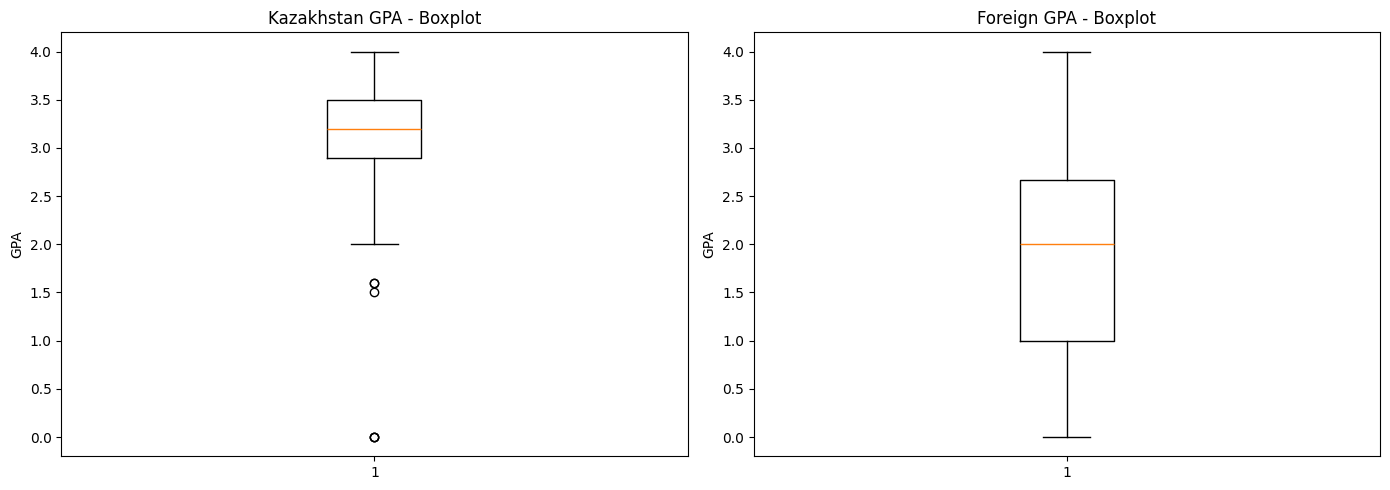

In [188]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].boxplot(kz_data_clean['gpa'].dropna())
axes[0].set_title('Kazakhstan GPA - Boxplot')
axes[0].set_ylabel('GPA')

axes[1].boxplot(foreign_data_clean['final_grade'].dropna())
axes[1].set_title('Foreign GPA - Boxplot')
axes[1].set_ylabel('GPA')

plt.tight_layout()
plt.savefig('/Users/kassi/Data Mining/Final/Code/figure/preprocessing/gpa_outliers_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()


# Handle outliers - Cap values

In [189]:
def cap_outliers(df, column, lower, upper):
    """Cap outliers to bounds"""
    df = df.copy()
    df[column] = df[column].clip(lower=lower, upper=upper)
    return df

In [190]:
def encode_categorical(df):
    """Encode categorical variables"""
    df = df.copy()
    
    # Identify categorical columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    
    print(f"Categorical columns: {list(categorical_cols)}")
    
    # Label Encoding for binary categories
    from sklearn.preprocessing import LabelEncoder
    
    le = LabelEncoder()
    
    for col in categorical_cols:
        unique_values = df[col].nunique()
        print(f"\n{col}: {unique_values} unique values")
        
        if unique_values == 2:
            # Binary encoding
            df[col + '_encoded'] = le.fit_transform(df[col])
            print(f"  Label encoded to {col}_encoded")
        else:
            # One-hot encoding
            dummies = pd.get_dummies(df[col], prefix=col, drop_first=True)
            df = pd.concat([df, dummies], axis=1)
            print(f"  One-hot encoded {len(dummies.columns)} columns")
    
    return df

print("=== Encoding Kazakhstan Data ===")
kz_data_encoded = encode_categorical(kz_data_clean)

print("\n=== Encoding Foreign Data ===")
foreign_data_encoded = encode_categorical(foreign_data_clean)

=== Encoding Kazakhstan Data ===
Categorical columns: ['university', 'course_year', 'gender', 'living_situation', 'mother_education', 'father_education', 'family_income', 'financial_support', 'emotional_support', 'travel_time', 'study_hours_weekly', 'extra_courses', 'class_absences', 'internet_access', 'has_computer', 'physical_activity', 'sleep_hours', 'nursery_school', 'romantic_relationship', 'alcohol_consumption', 'peer_support', 'employment_status']

university: 30 unique values
  One-hot encoded 29 columns

course_year: 6 unique values
  One-hot encoded 5 columns

gender: 2 unique values
  Label encoded to gender_encoded

living_situation: 4 unique values
  One-hot encoded 3 columns

mother_education: 4 unique values
  One-hot encoded 3 columns

father_education: 4 unique values
  One-hot encoded 3 columns

family_income: 4 unique values
  One-hot encoded 3 columns

financial_support: 3 unique values
  One-hot encoded 2 columns

emotional_support: 4 unique values
  One-hot encode

In [191]:
print(f"Kazakhstan shape after encoding: {kz_data_encoded.shape}")
print(f"Foreign shape after encoding: {foreign_data_encoded.shape}")

Kazakhstan shape after encoding: (121, 125)
Foreign shape after encoding: (649, 74)


# Feature Engineering

In [192]:
def create_features(df):
    """Create additional features"""
    df = df.copy()
    
    # Example: Create age groups if age exists
    if 'Age' in df.columns:
        df['Age_Group'] = pd.cut(df['Age'], 
                                  bins=[0, 20, 22, 25, 100], 
                                  labels=['18-20', '20-22', '22-25', '25+'])
    
    # Example: Family size categories
    if 'Family_Size' in df.columns:
        df['Family_Size_Category'] = pd.cut(df['Family_Size'],
                                            bins=[0, 3, 5, 100],
                                            labels=['Small', 'Medium', 'Large'])
    
    # Example: Parental education level
    if 'Father_Education' in df.columns and 'Mother_Education' in df.columns:
        # Assume education levels are numeric or encoded
        df['Avg_Parental_Education'] = (df['Father_Education'] + df['Mother_Education']) / 2
    
    return df

kz_data_featured = create_features(kz_data_encoded)
foreign_data_featured = create_features(foreign_data_encoded)

print("Feature engineering completed!")


Feature engineering completed!


# Final Data Quality Check

In [193]:
def data_quality_report(df, name):
    """Generate data quality report"""
    print(f"\n{'='*50}")
    print(f"{name} - Data Quality Report")
    print(f"{'='*50}")
    
    print(f"Shape: {df.shape}")
    print(f"Missing values: {df.isnull().sum().sum()}")
    print(f"Duplicate rows: {df.duplicated().sum()}")
    
    print("\nData types:")
    print(df.dtypes.value_counts())
    
    print("\nNumerical columns summary:")
    print(df.describe())

data_quality_report(kz_data_featured, "Kazakhstan")
data_quality_report(foreign_data_featured, "Foreign")


Kazakhstan - Data Quality Report
Shape: (121, 125)
Missing values: 121
Duplicate rows: 0

Data types:
bool       92
object     22
int64       8
float64     3
Name: count, dtype: int64

Numerical columns summary:
              age  family_size  academic_failures  study_space_comfort  \
count  121.000000   121.000000         121.000000           121.000000   
mean    20.173554     5.743802           0.471074             3.925620   
std      3.179826     2.403223           0.719657             1.017884   
min     16.000000     2.000000           0.000000             1.000000   
25%     19.000000     5.000000           0.000000             3.000000   
50%     20.000000     5.000000           0.000000             4.000000   
75%     21.000000     7.000000           1.000000             5.000000   
max     50.000000    20.000000           2.000000             5.000000   

       health_status  academic_stress         gpa  gender_encoded  \
count     121.000000              0.0  121.000000  

# Save Cleaned Datasets

In [194]:
kz_data_featured.to_csv('/Users/kassi/Data Mining/Final/Code/data/data_clean/kz_data_en_clean.csv', index=False)
foreign_data_featured.to_csv('/Users/kassi/Data Mining/Final/Code/data/data_clean/student_portuguese_clean.csv', index=False)

In [195]:
preprocessing_report = {
    'Dataset': ['Kazakhstan', 'Foreign'],
    'Original_Rows': [kz_data.shape[0], foreign_data.shape[0]],
    'Final_Rows': [kz_data_featured.shape[0], foreign_data_featured.shape[0]],
    'Original_Cols': [kz_data.shape[1], foreign_data.shape[1]],
    'Final_Cols': [kz_data_featured.shape[1], foreign_data_featured.shape[1]],
    'Rows_Dropped': [kz_data.shape[0] - kz_data_featured.shape[0], 
                     foreign_data.shape[0] - foreign_data_featured.shape[0]]
}

preprocessing_df = pd.DataFrame(preprocessing_report)
preprocessing_df.to_csv('/Users/kassi/Data Mining/Final/Code/report/preprocessing/preprocessing_report.csv', index=False)
print("\nPreprocessing report saved!")


Preprocessing report saved!
